<a href="https://colab.research.google.com/github/quantority/master-s-degree-projects/blob/main/Hometasks/Base/AI_HW4_woodenML_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 2 февраля 23:59

**Продуктивной и интересной вам работы!**

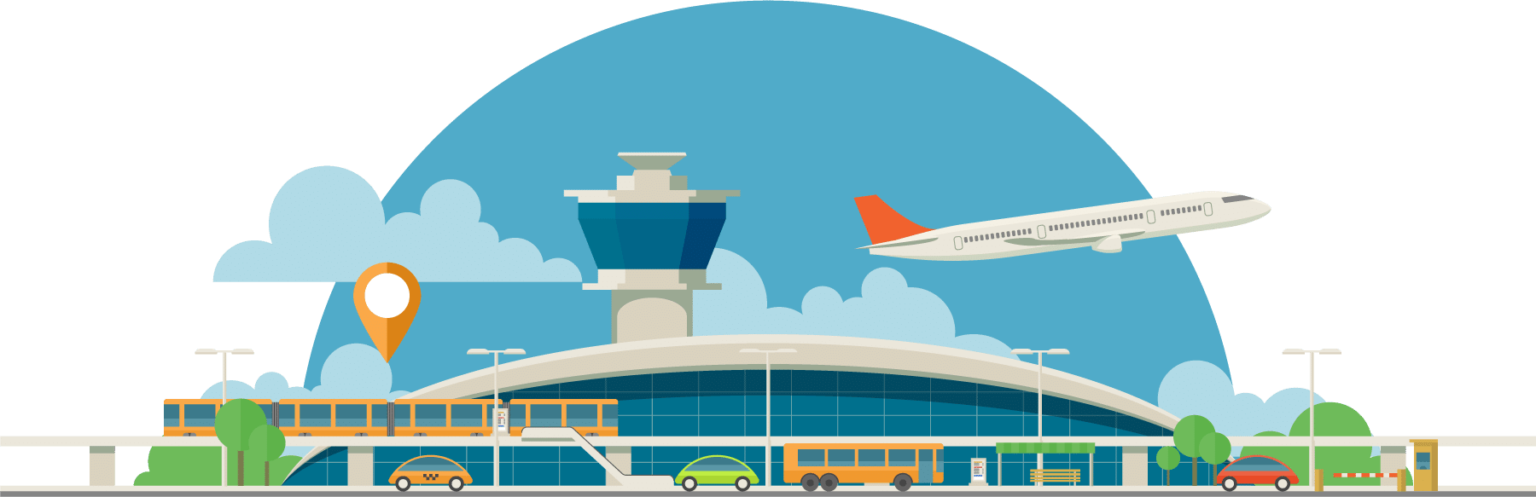

In [1]:
# установка всех библиотек, необходимых для выполнения ДЗ

!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [3]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-02-15 15:00:42--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2025-02-15 15:00:43 (1.54 GB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

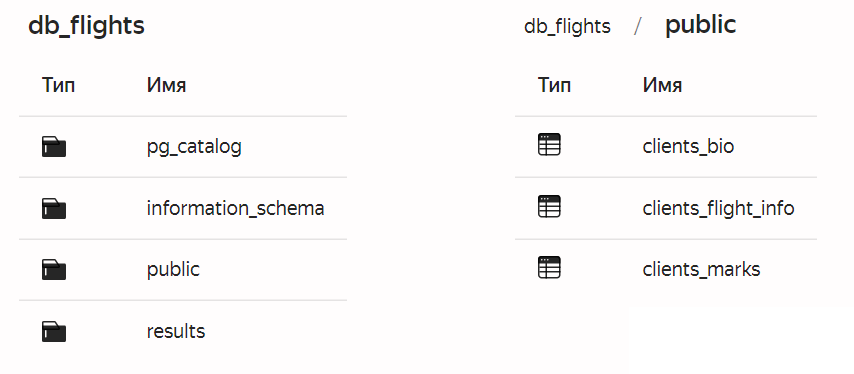



In [4]:
# Ваш код здесь

params = {
    "host":"rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
    "port":"6432",
    "sslmode":"verify-full",
    "dbname":"db_flights",
    "user":"mlhs_student",
    "password":"mlhs_student",
    "target_session_attrs":"read-write"
    }

In [5]:
conn = psycopg2.connect(**params)

In [6]:
cursor = conn.cursor()

In [7]:
cursor.execute('SELECT bio.*, info.*, marks.* FROM public.clients_bio AS bio INNER JOIN public.clients_flight_info AS info ON bio.id = info.id INNER JOIN public.clients_marks AS marks ON bio.id = marks.id')

In [8]:
col_names = [desc[0] for desc in cursor.description]

In [9]:
df = pd.DataFrame(cursor.fetchall(), columns=col_names)

In [10]:
cursor.close()
conn.close()

In [11]:
df = df.loc[:, ~df.columns.duplicated()].set_index('id')

In [12]:
assert df.shape == (129_549, 23)

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [13]:
# Ваш код ниже
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   gender                             129549 non-null  object
 1   age                                129549 non-null  object
 2   Customer Type                      129549 non-null  object
 3   Type of Travel                     129549 non-null  object
 4   class                              129549 non-null  object
 5   Flight Distance                    129549 non-null  object
 6   Departure Delay in Minutes         129549 non-null  object
 7   Arrival Delay in Minutes           129549 non-null  object
 8   Inflight wifi service              129549 non-null  object
 9   Departure/Arrival time convenient  129549 non-null  object
 10  Ease of Online booking             129549 non-null  object
 11  Gate location                      129549 non-null  objec

In [14]:
df.replace('nan', np.NaN, inplace=True)

In [15]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='ignore')

<ipython-input-15-d6a3b622c820>:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


In [16]:
df.isna().sum()

,0
gender,0
age,315
Customer Type,77
Type of Travel,101
class,116
Flight Distance,94
Departure Delay in Minutes,107
Arrival Delay in Minutes,507
Inflight wifi service,44
Departure/Arrival time convenient,49


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


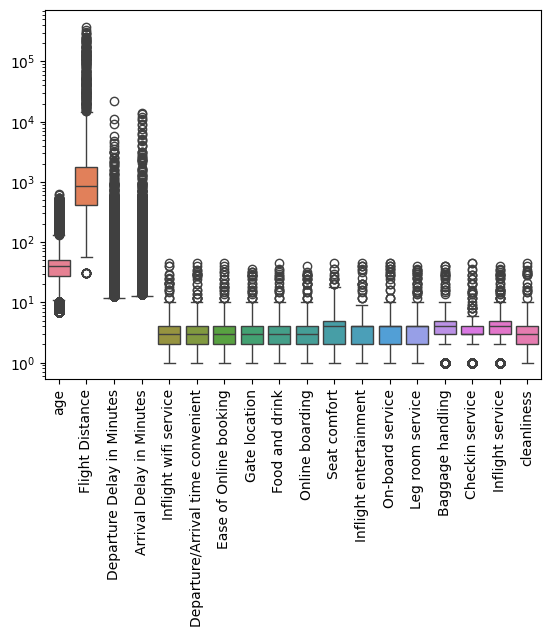

In [17]:
sns.boxplot(df.select_dtypes(include=['number']), log_scale=True)
plt.xticks(rotation=90)
plt.show()

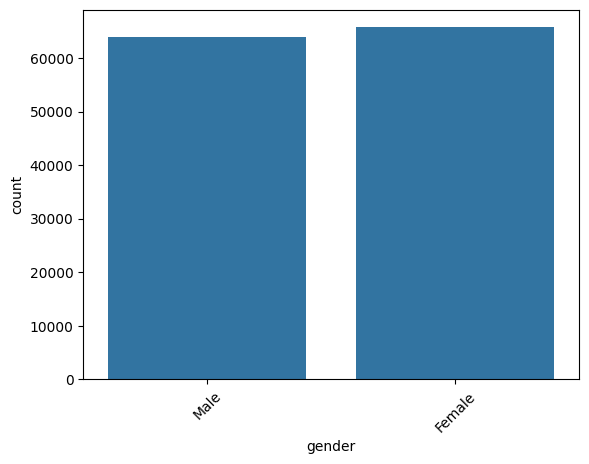

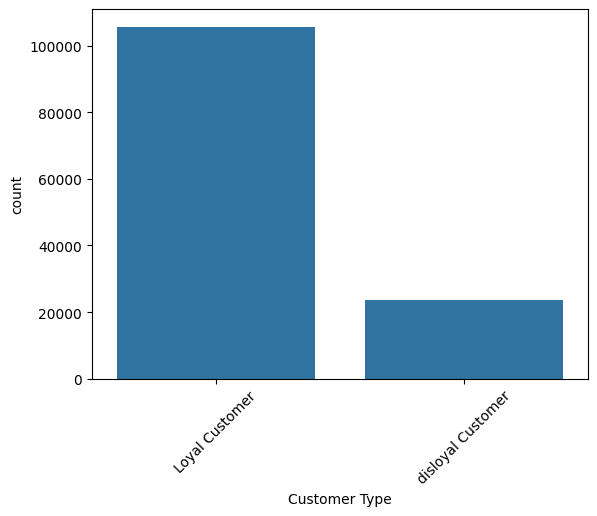

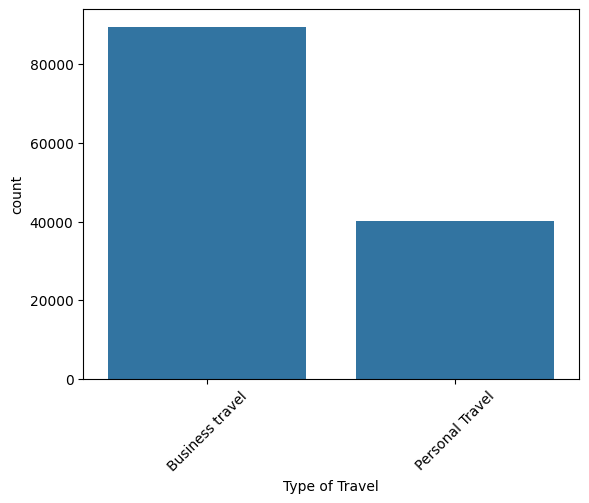

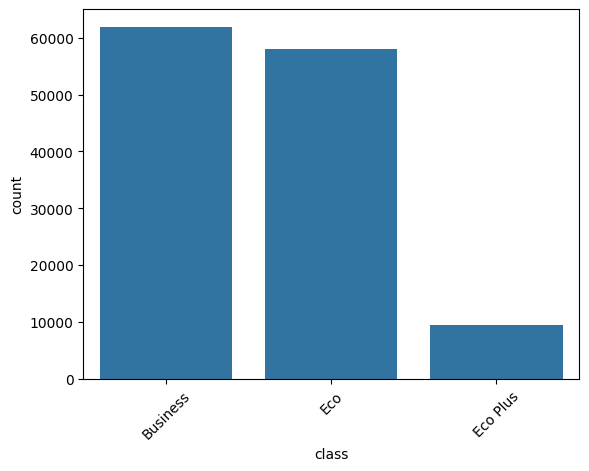

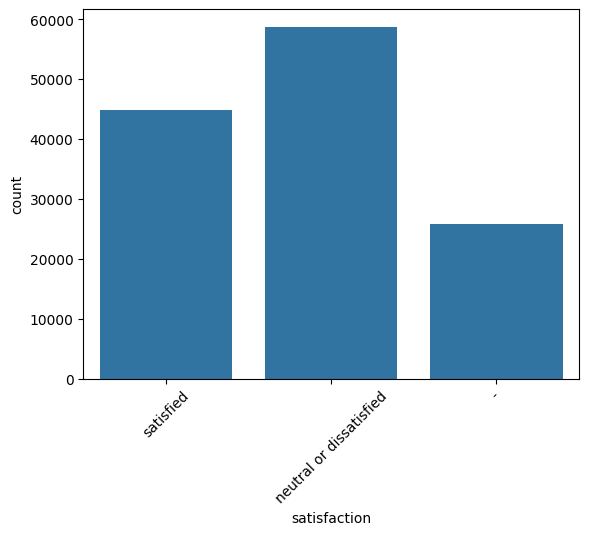

In [18]:
for col in df.select_dtypes(include=['object']).columns:
  sns.countplot(x=df[col])
  plt.xticks(rotation=45)
  plt.show()

### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

<Axes: >

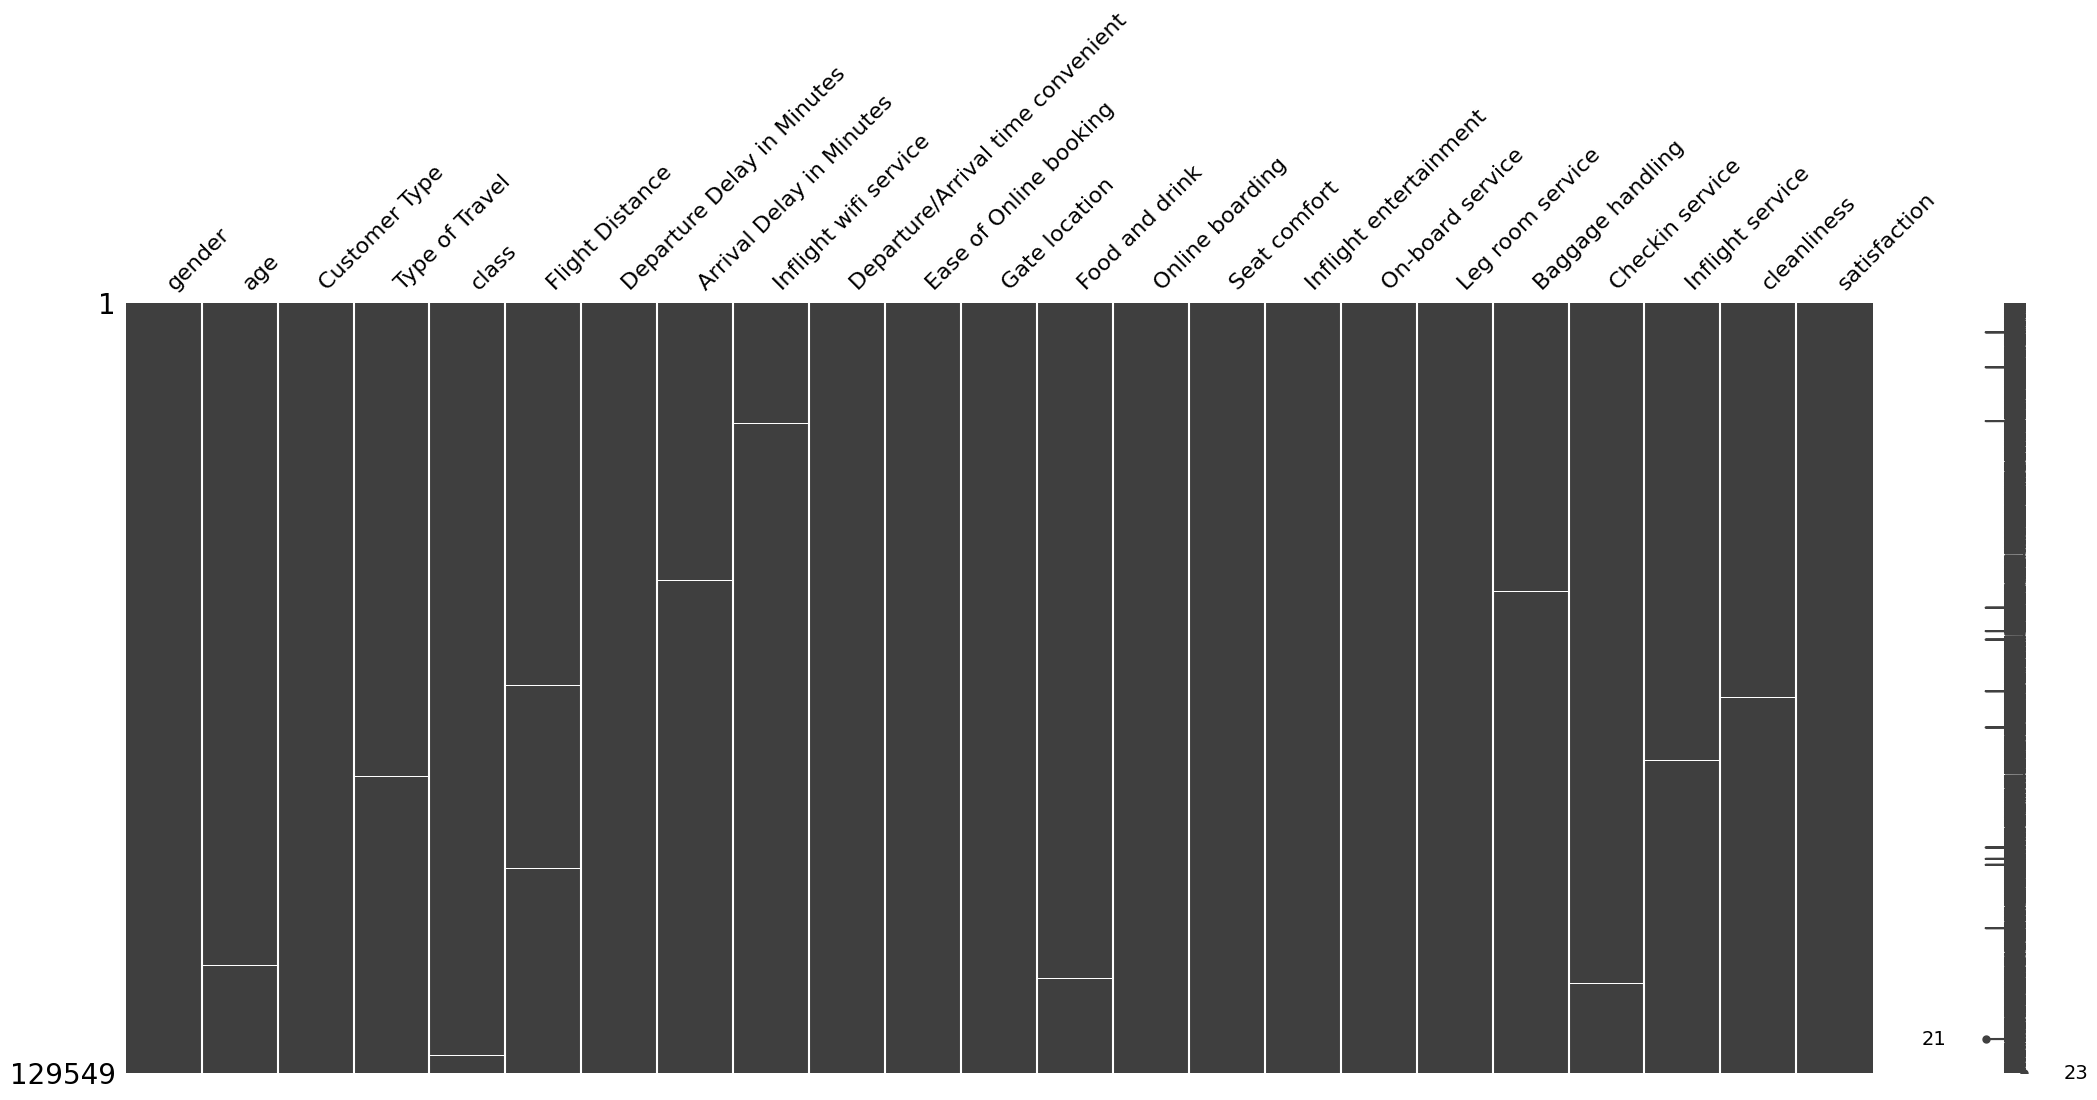

In [19]:
# Ваш код ниже
missingno.matrix(df)

/usr/local/lib/python3.11/dist-packages/missingno/missingno.py:271: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([int(n * len(df)) for n in ax1.get_yticks()], fontsize=fontsize)


<Axes: >

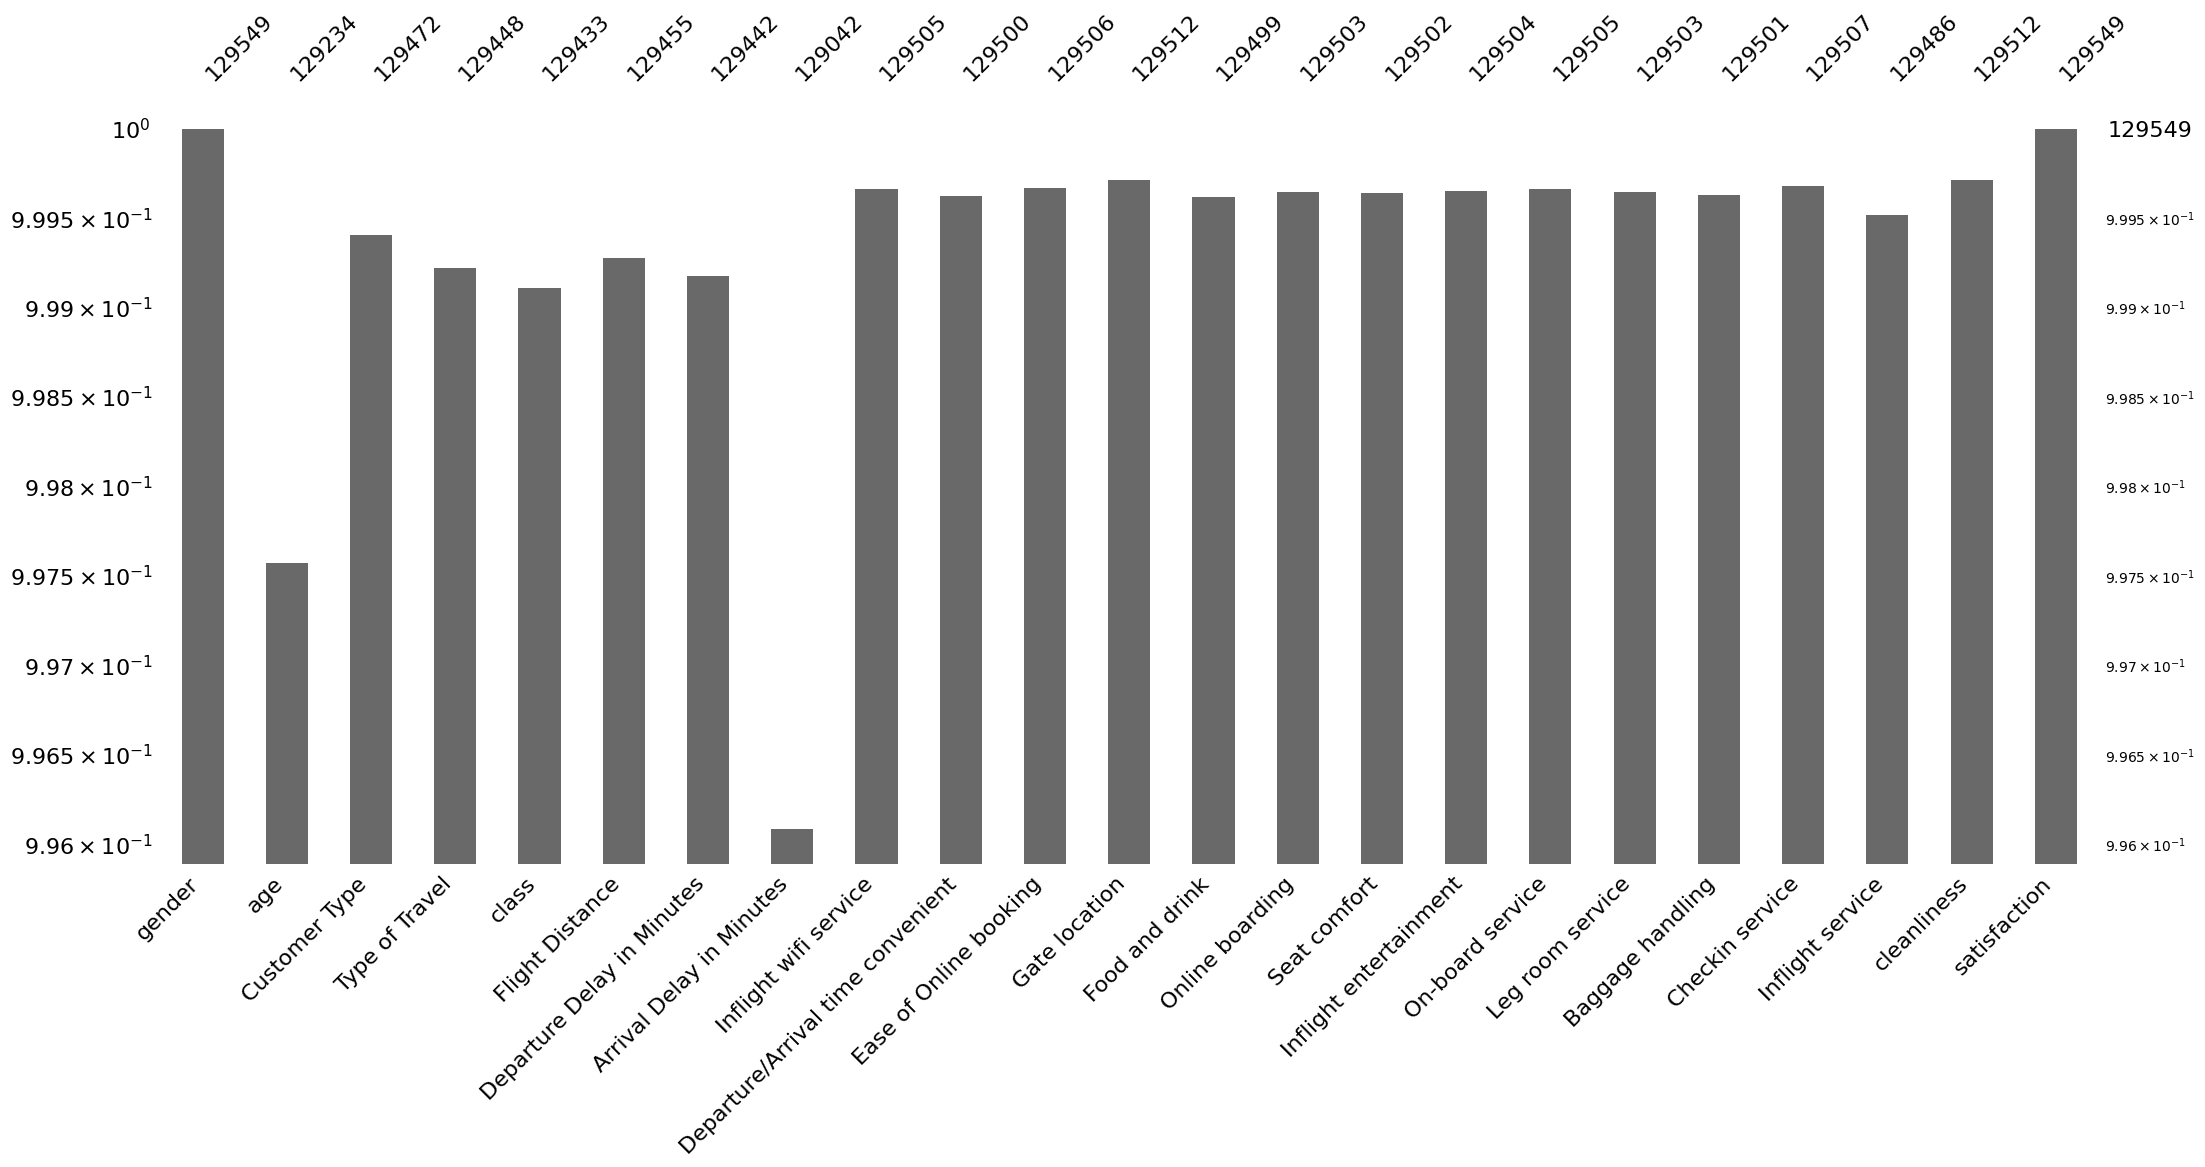

In [20]:
# Ваш код ниже

missingno.bar(df, log=True)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [21]:
df_train = df[df.satisfaction != '-']
df_train

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,satisfaction
id,,,,,,,,,,,,,,,,,,,,,
7,Male,43.0,Loyal Customer,Business travel,Business,1963.0,0.0,0.0,3.0,3.0,...,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,satisfied
13,Male,24.0,disloyal Customer,Business travel,Eco,453.0,16.0,30.0,2.0,2.0,...,2.0,5.0,5.0,2.0,4.0,4.0,2.0,4.0,5.0,neutral or dissatisfied
18,Female,61.0,Loyal Customer,Personal Travel,Eco,821.0,0.0,0.0,2.0,5.0,...,1.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,1.0,neutral or dissatisfied
31,Male,35.0,disloyal Customer,Business travel,Business,212.0,0.0,0.0,2.0,2.0,...,2.0,2.0,2.0,4.0,5.0,5.0,5.0,4.0,2.0,neutral or dissatisfied
39,Female,46.0,Loyal Customer,Business travel,Business,67.0,0.0,0.0,3.0,3.0,...,5.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129831,Female,28.0,Loyal Customer,Personal Travel,Eco,447.0,23.0,16.0,1.0,3.0,...,1.0,3.0,3.0,1.0,1.0,4.0,1.0,5.0,3.0,neutral or dissatisfied
129837,Male,66.0,Loyal Customer,Personal Travel,Eco,337.0,199.0,213.0,2.0,4.0,...,5.0,5.0,5.0,2.0,4.0,5.0,5.0,4.0,5.0,neutral or dissatisfied
129838,Female,59.0,Loyal Customer,Personal Travel,Eco,308.0,32.0,24.0,3.0,5.0,...,5.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,neutral or dissatisfied


In [22]:
assert df_train.shape == (103_644, 23)

In [23]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
id,,,,,,,,,,,,,,,,,,,,,
55,Male,36.0,Loyal Customer,Business travel,Business,3655.0,40.0,71.0,1.0,1.0,...,1.0,3.0,3.0,3.0,3.0,3.0,1.0,4.0,3.0,2.0
79,Female,70.0,Loyal Customer,Personal Travel,Eco,108.0,50.0,41.0,5.0,4.0,...,4.0,4.0,4.0,3.0,3.0,0.0,3.0,5.0,3.0,5.0
126,Male,66.0,Loyal Customer,Personal Travel,Eco,562.0,88.0,84.0,2.0,5.0,...,5.0,2.0,5.0,5.0,3.0,5.0,2.0,5.0,5.0,5.0
199,Female,60.0,Loyal Customer,Business travel,Business,3756.0,36.0,24.0,4.0,4.0,...,2.0,4.0,5.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0
263,Male,43.0,Loyal Customer,Personal Travel,Business,802.0,0.0,0.0,1.0,2.0,...,2.0,3.0,3.0,2.0,2.0,1.0,2.0,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129750,Male,38.0,Loyal Customer,Business travel,Eco,337.0,92.0,82.0,4.0,3.0,...,4.0,5.0,4.0,4.0,4.0,5.0,4.0,5.0,3.0,4.0
129771,Male,16.0,Loyal Customer,Personal Travel,Eco,308.0,2.0,0.0,3.0,4.0,...,1.0,3.0,5.0,1.0,4.0,2.0,5.0,5.0,4.0,1.0
129798,Female,43.0,Loyal Customer,Personal Travel,Eco,308.0,0.0,0.0,2.0,4.0,...,3.0,5.0,5.0,4.0,4.0,2.0,4.0,4.0,4.0,5.0


In [24]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [25]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [26]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [27]:
# Ваш код ниже

for frame in [X_train, X_val, df_test]:
  for col in frame.columns:
    frame[col].fillna(X_train[col].mode().values[0], inplace=True)

<ipython-input-27-fdc233a7a1e5>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  frame[col].fillna(X_train[col].mode().values[0], inplace=True)


### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [28]:
# Ваш код ниже
display(df.describe(include='number'))

display(df.select_dtypes(include=['O']).describe())

,age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
count,129234.000000,129455.000000,129442.000000,129042.000000,129505.000000,129500.000000,129506.000000,129512.000000,129499.000000,129503.000000,129502.000000,129504.000000,129505.000000,129503.000000,129501.000000,129507.000000,129486.000000,129512.000000
mean,40.116951,1322.922158,15.809026,16.656499,2.732327,3.062131,2.760722,2.981708,3.208141,3.256782,3.445669,3.361232,3.387259,3.355976,3.635872,3.309976,3.646927,3.289780
std,20.376129,4517.816532,93.276882,109.285072,1.360033,1.559627,1.431048,1.312873,1.357546,1.381888,1.349713,1.366908,1.335697,1.361670,1.222039,1.298827,1.218748,1.347466
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,40.000000,846.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,51.000000,1744.000000,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,621.000000,379620.000000,22227.000000,14006.000000,45.000000,45.000000,45.000000,36.000000,45.000000,40.000000,45.000000,45.000000,45.000000,40.000000,40.000000,45.000000,40.000000,45.000000


,gender,Customer Type,Type of Travel,class,satisfaction
count,129549,129472,129448,129433,129549
unique,2,2,2,3,3
top,Female,Loyal Customer,Business travel,Business,neutral or dissatisfied
freq,65726,105763,89405,61939,58732


`Ваш ответ здесь`

### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [29]:
# Ваш код ниже

for col in X_train.select_dtypes(include=['number']):
  X_train = X_train[X_train[col] <= X_train[col].quantile(q=.996)]

y_train = y_train.loc[y_train.index.isin(X_train.index)]

for col in X_val.select_dtypes(include=['number']):
  X_val = X_val[X_val[col] <= X_val[col].quantile(q=.996)]

y_val = y_val.loc[y_val.index.isin(X_val.index)]

In [30]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [31]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [32]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [33]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for col in cols:
      sns.countplot(x=df[col]).set(title=f'{col} distribution')
      plt.xticks(rotation=45)
      plt.show()
    pass


In [34]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row
    for all columns in 'cols' with informative title
    """
    for col in cols:
      fig, axes = plt.subplots(1, 2)
      sns.histplot(df[col], ax=axes[0])
      sns.boxplot(x=df[col], ax=axes[1])
      fig.suptitle(f'{col} distribution')
      plt.show()
    pass

In [35]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    for col in cols:
      sns.countplot(x=df[col]).set(title=f'{col} distribution')
      plt.show()
    pass

Отрисовка.

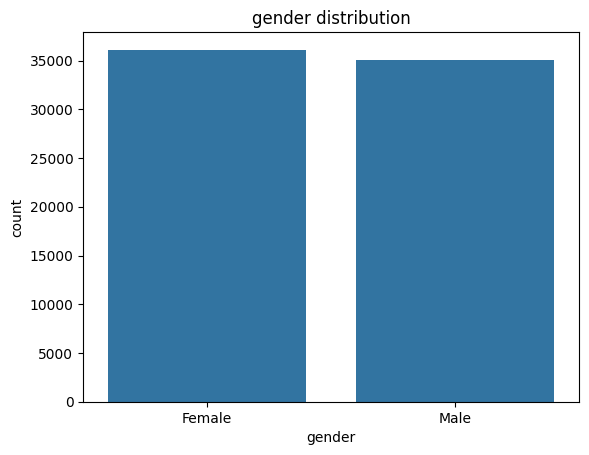

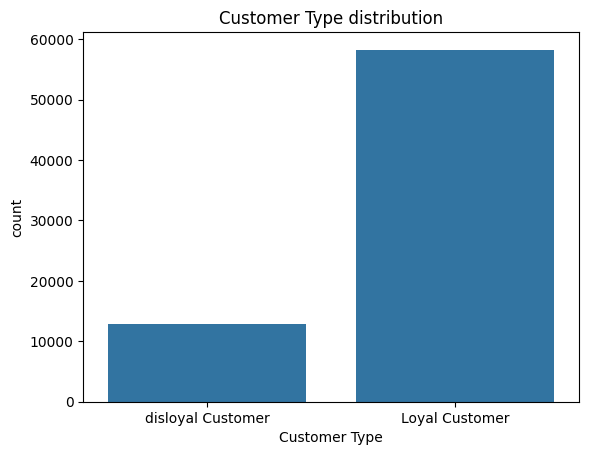

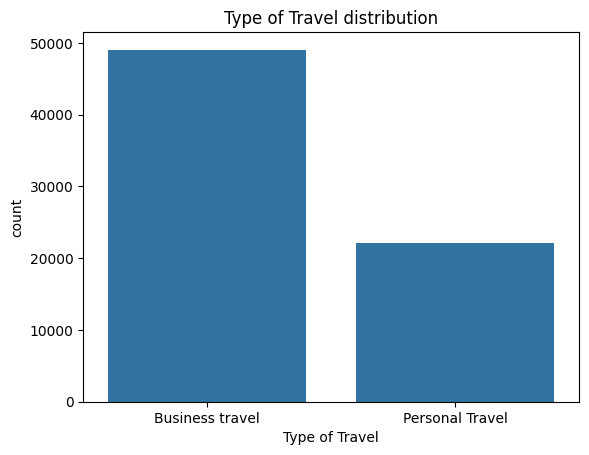

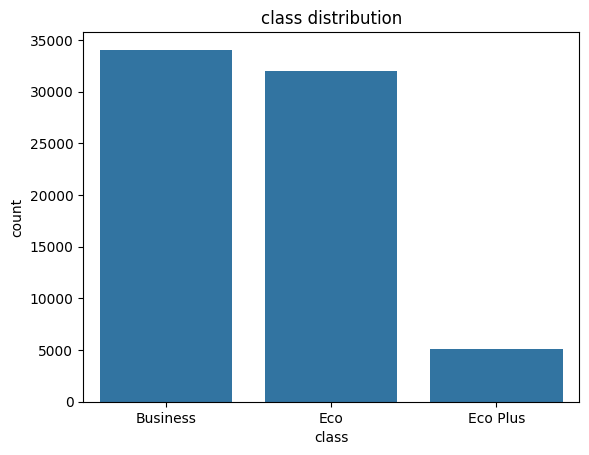

In [36]:
plot_categorical(categorical_cols, X_train, y_train)

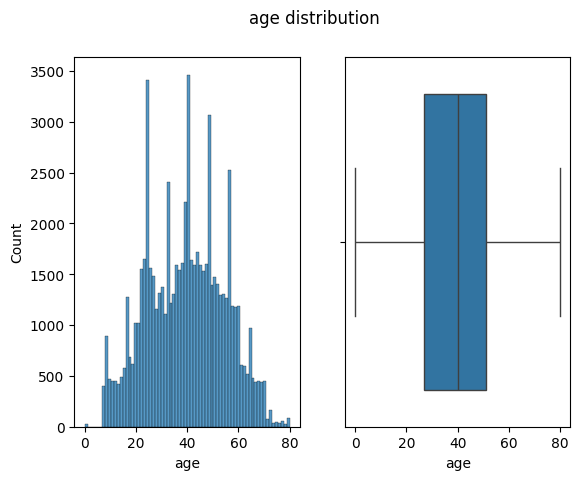

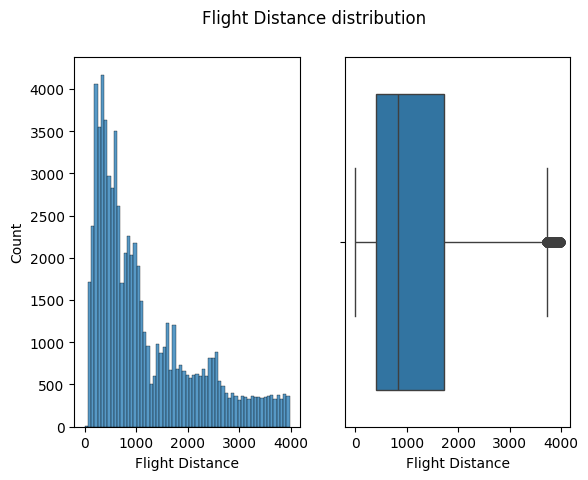

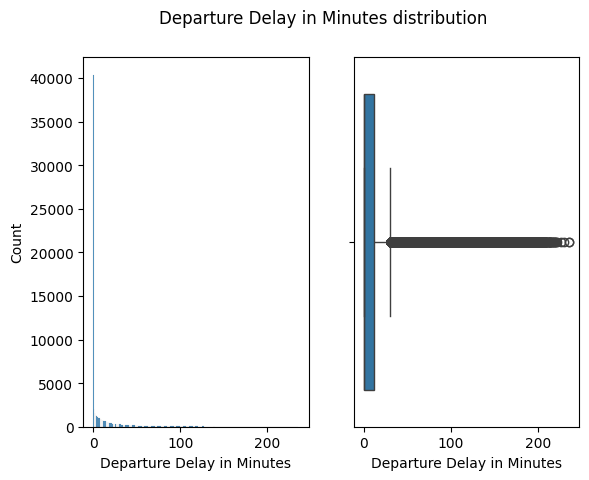

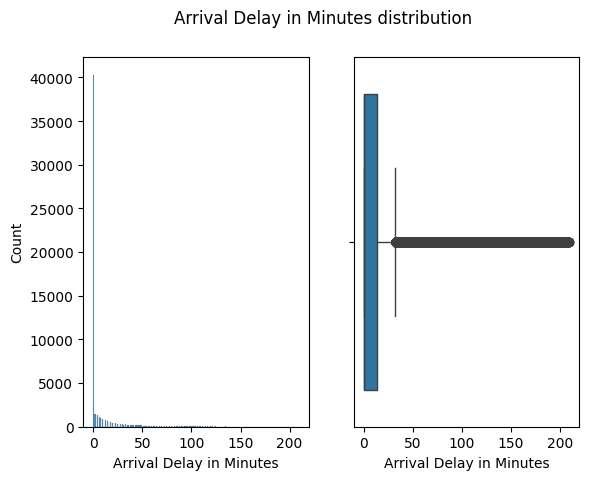

In [37]:
plot_continuous(continuous_cols, X_train, y_train)

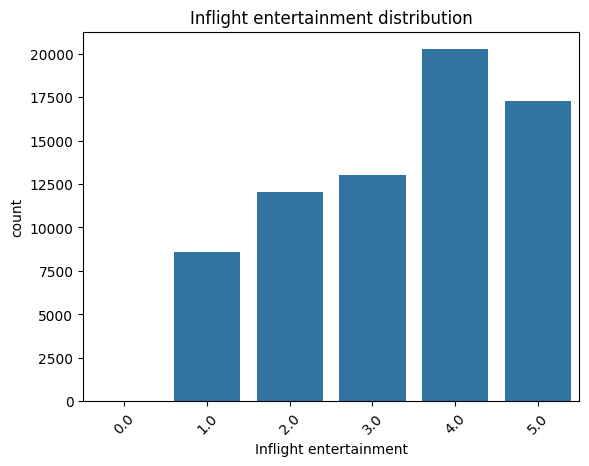

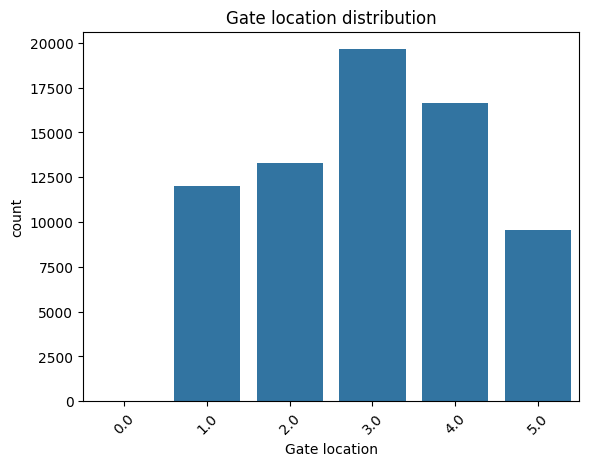

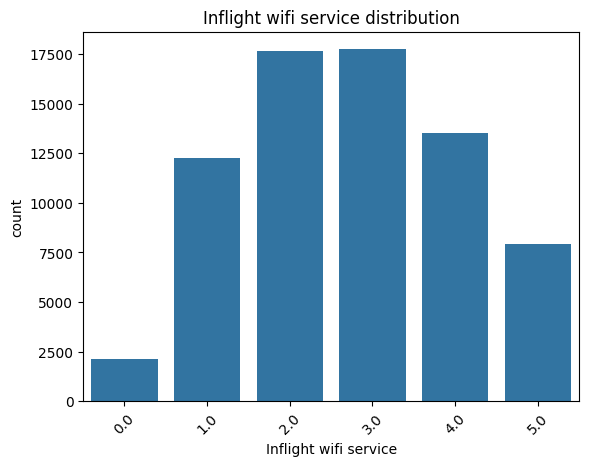

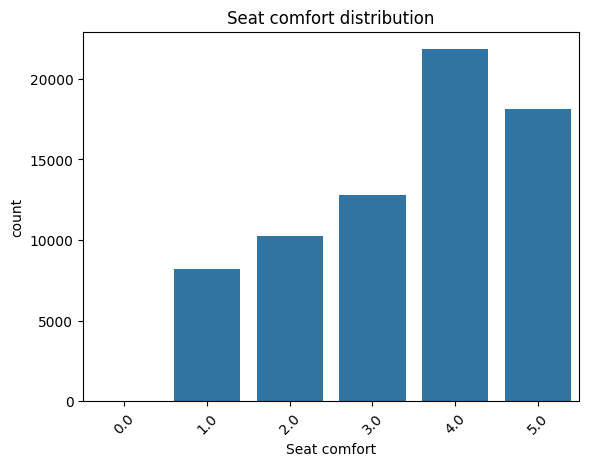

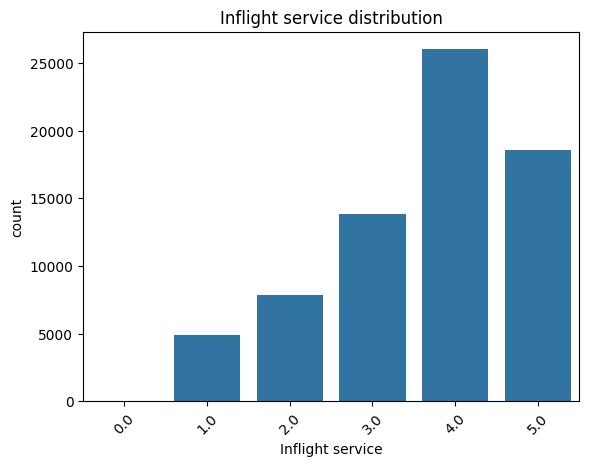

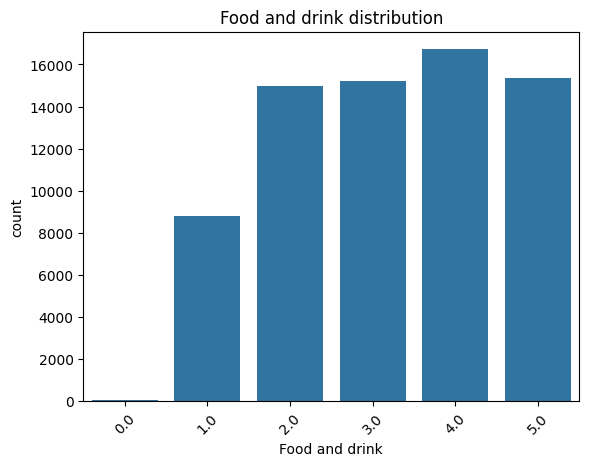

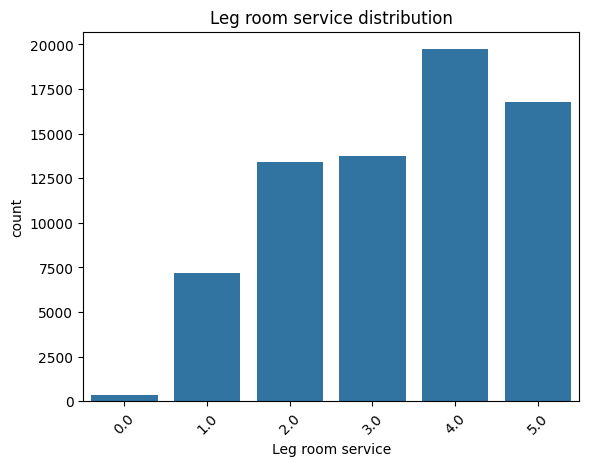

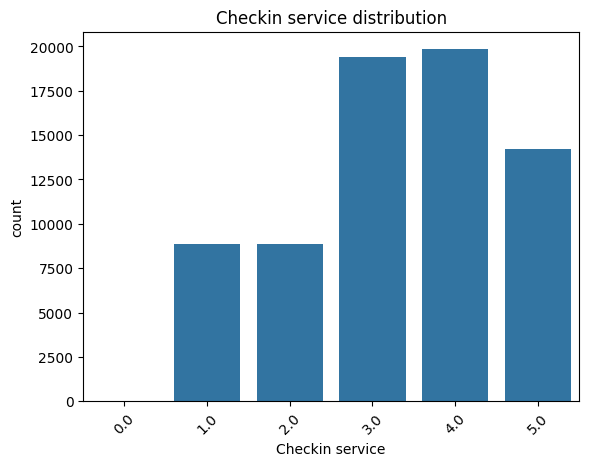

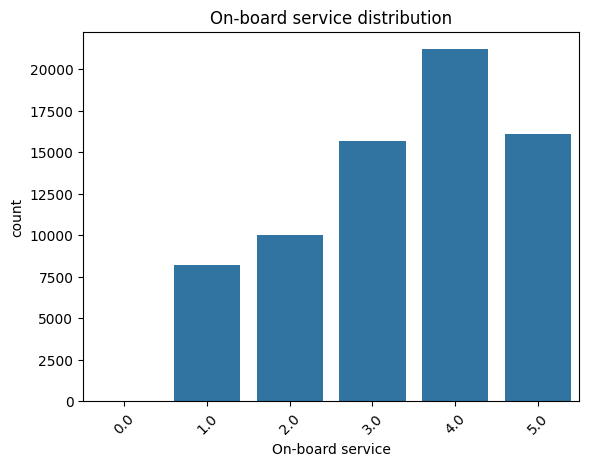

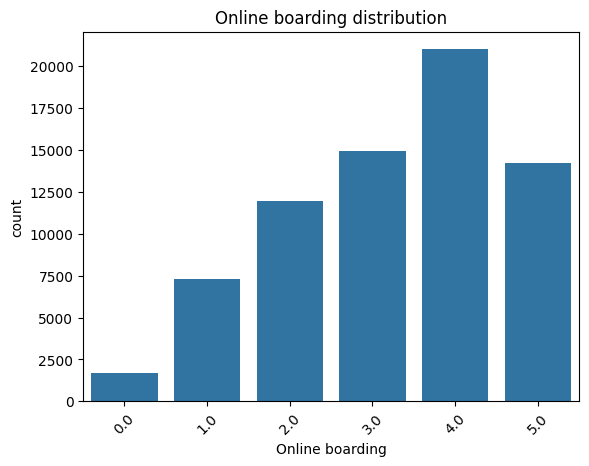

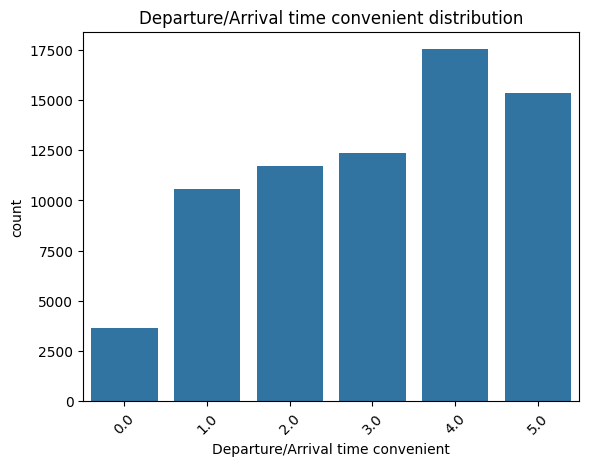

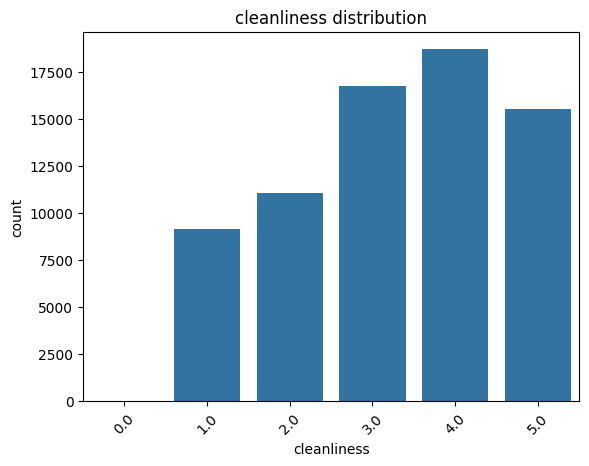

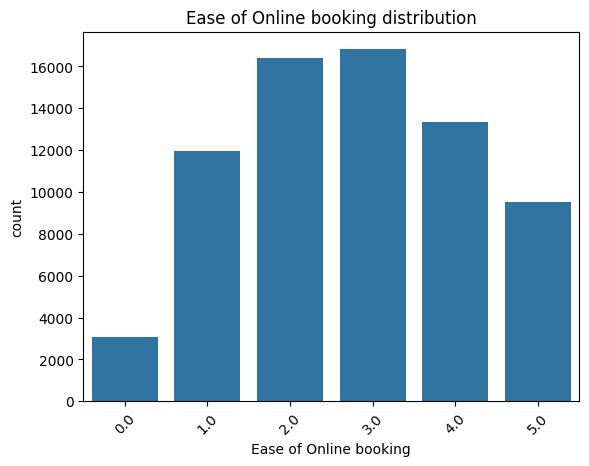

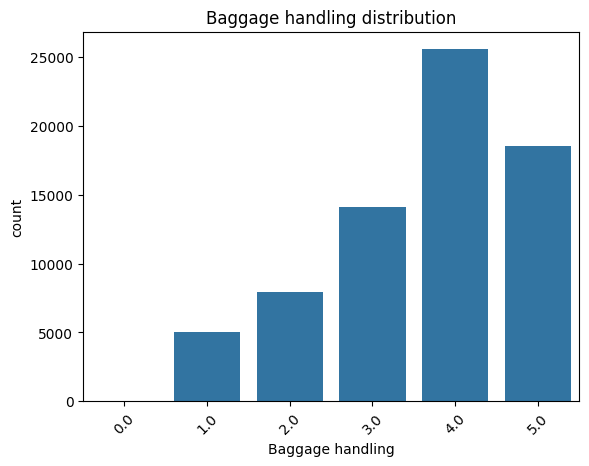

In [38]:
plot_ordinal(ordinal_cols, X_train, y_train)

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки


```
<Большинство признаков не имеют равномерное распределение, классы сбалансированы, среди континуальных признаков есть распределения похожие на нормальное и геометрические распределения
```



### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

In [39]:
# Ваш код ниже


### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [40]:
# Ваш код ниже

X_train[['Departure Delay in Minutes', 'Arrival Delay in Minutes']] = np.log1p(X_train[['Departure Delay in Minutes', 'Arrival Delay in Minutes']])

Построение.

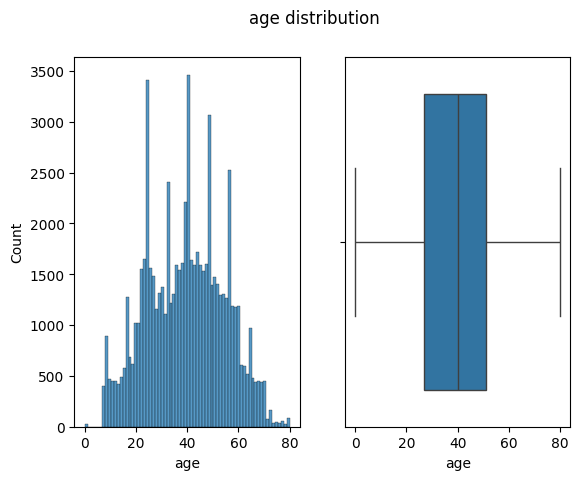

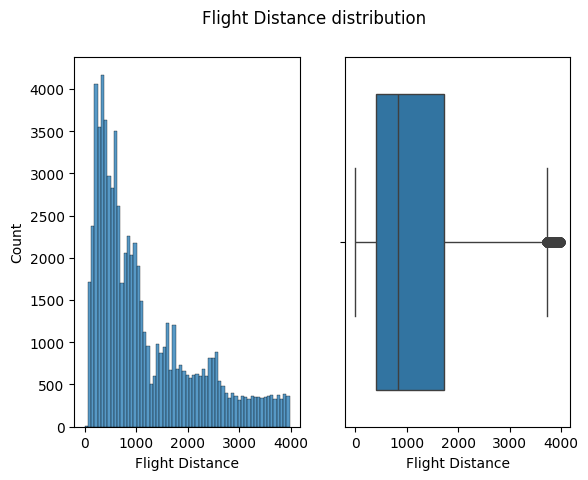

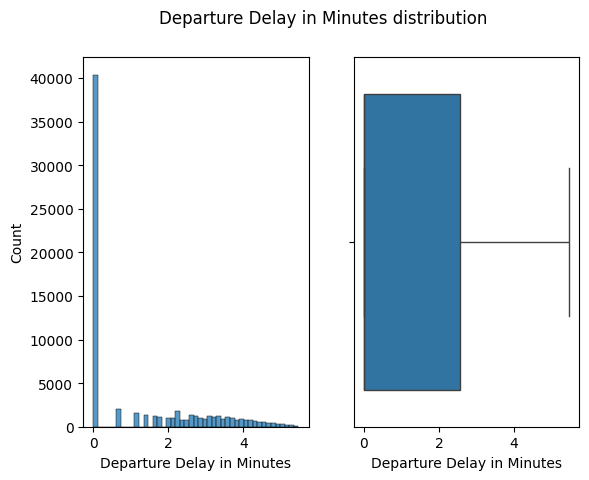

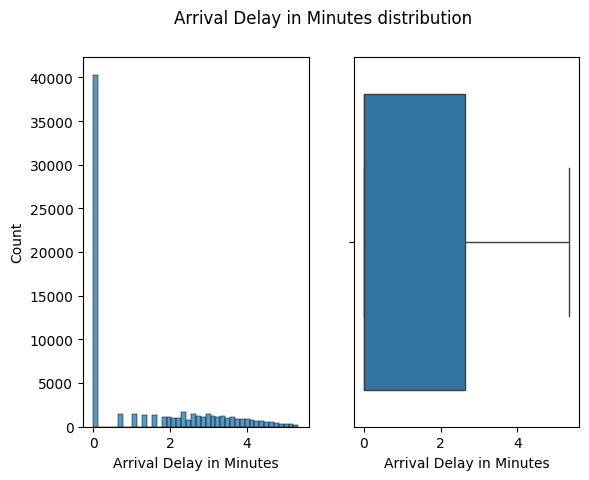

In [41]:
plot_continuous(continuous_cols, X_train, y_train)

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

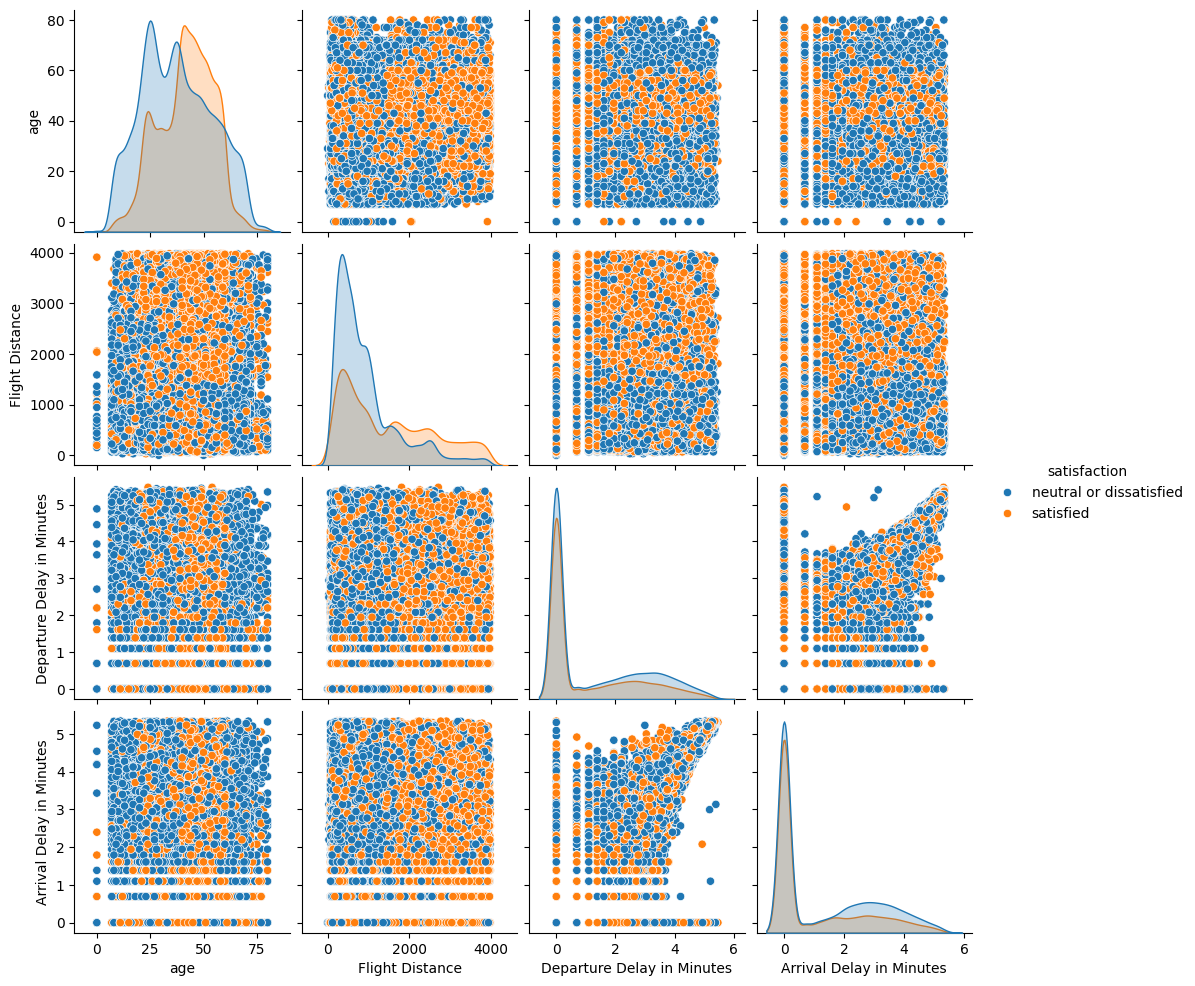

In [42]:
# Ваш код ниже

sns.pairplot(pd.concat([X_train[continuous_cols], y_train], axis=1), hue='satisfaction')

# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [43]:
# Ваш код ниже
y_train = y_train.apply(lambda x: 1 if x == 'satisfied' else 0)

y_val = y_val.apply(lambda x: 1 if x == 'satisfied' else 0)

In [44]:
ohe = OneHotEncoder(sparse_output=False)

X_train_cat = ohe.fit_transform(X_train[categorical_cols])

X_val_cat = ohe.transform(X_val[categorical_cols])

In [45]:
X_train_cat = pd.DataFrame(X_train_cat, columns=ohe.get_feature_names_out(categorical_cols))

X_val_cat = pd.DataFrame(X_val_cat, columns=ohe.get_feature_names_out(categorical_cols))

In [46]:
X_train = pd.concat([X_train[continuous_cols+ordinal_cols].reset_index(drop=True), X_train_cat], axis=1)

In [47]:
X_val = pd.concat([X_val[continuous_cols+ordinal_cols].reset_index(drop=True), X_val_cat], axis=1)

### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [48]:
y_train.value_counts(normalize=True)

,proportion
satisfaction,
0,0.566828
1,0.433172


In [49]:
# Ваш код ниже
dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)

prediction = dt.predict(X_val)

accuracy_score(y_val, prediction)

0.9322250639386189

## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [50]:
# Ваш код ниже — дополните его

error_dt, bias_dt, var_dt = bias_variance_decomp(dt, X_train.values, y_train.values, X_val.values, y_val.values, loss ='0-1_loss')
error_dt, bias_dt, var_dt

(0.07093465145255427, 0.04219948849104859, 0.05528051019738999)

`Не понимаю, почему дисперсия и смещение больше ошибки ((( В ошибку немного больший вклад вносит разброс`

### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [55]:
# Ваш код ниже

print('Глубина дерева:', dt.get_depth())

print('Количество листьев:', dt.get_n_leaves())

Глубина дерева: 34
Количество листьев: 1975


### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

In [57]:
# Ваш код здесь

feature_df = pd.DataFrame({'Признаки':X_train.columns, 'Важность':dt.feature_importances_}).sort_values(by='Важность', ascending=False)

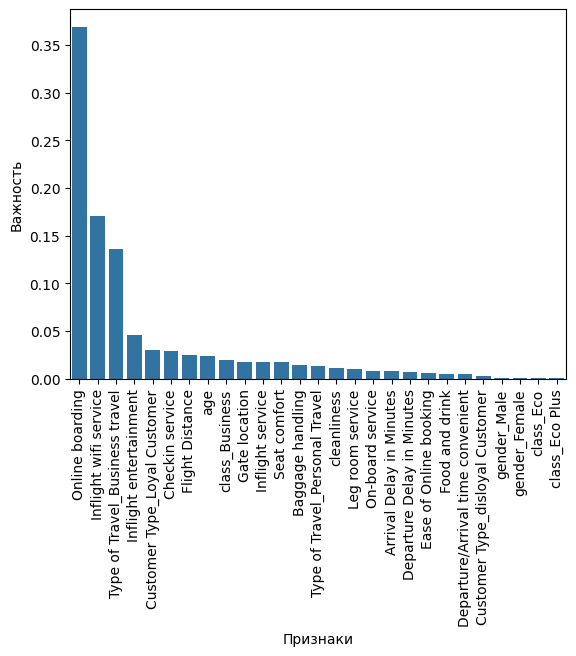

In [58]:
sns.barplot(x='Признаки', y='Важность', data=feature_df)
plt.xticks(rotation=90)
plt.show()

`Online boarding, inflight wifi service, type of travel_buisness travel`  

### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [59]:
# Ваш код здесь
model = DecisionTreeClassifier(max_depth=5)

model.fit(X_train[['Online boarding', 'Inflight wifi service']], y_train)

prediction = model.predict(X_val[['Online boarding', 'Inflight wifi service']])

accuracy_score(y_val, prediction)

0.8251032854613417

### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

In [60]:
dot = export_graphviz(model, out_file=None, feature_names=X_train[['Online boarding', 'Inflight wifi service']].columns,
                      class_names=[str(i) for i in model.classes_], filled=True, rounded=True, special_characters=True)

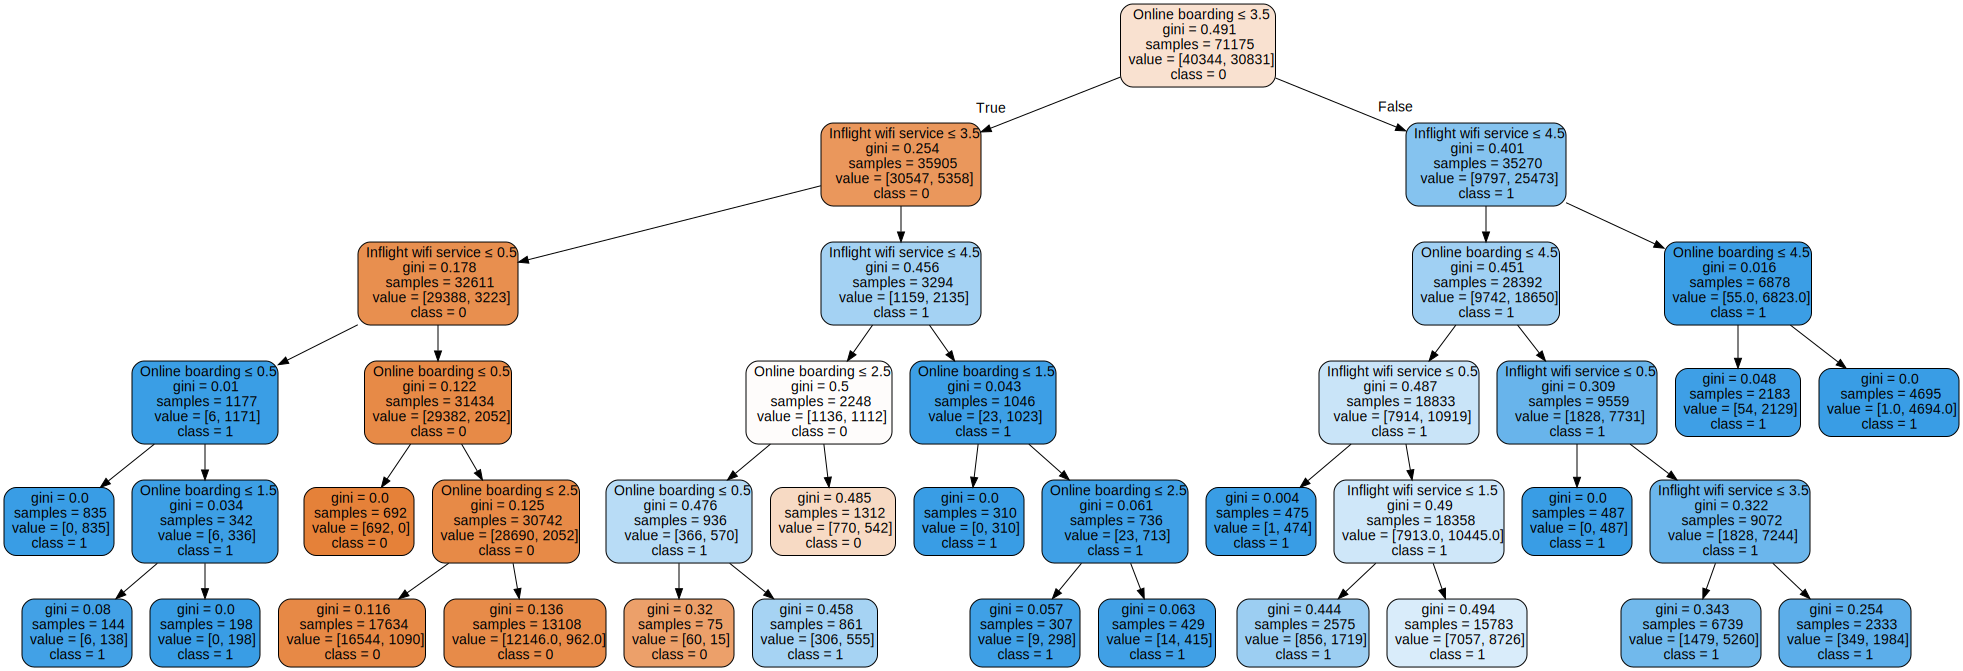

In [61]:
graph = Source(dot)
graph

`Ваш ответ здесь. `

*Гуглить — можно, но помните о культуре цитирования.*

### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

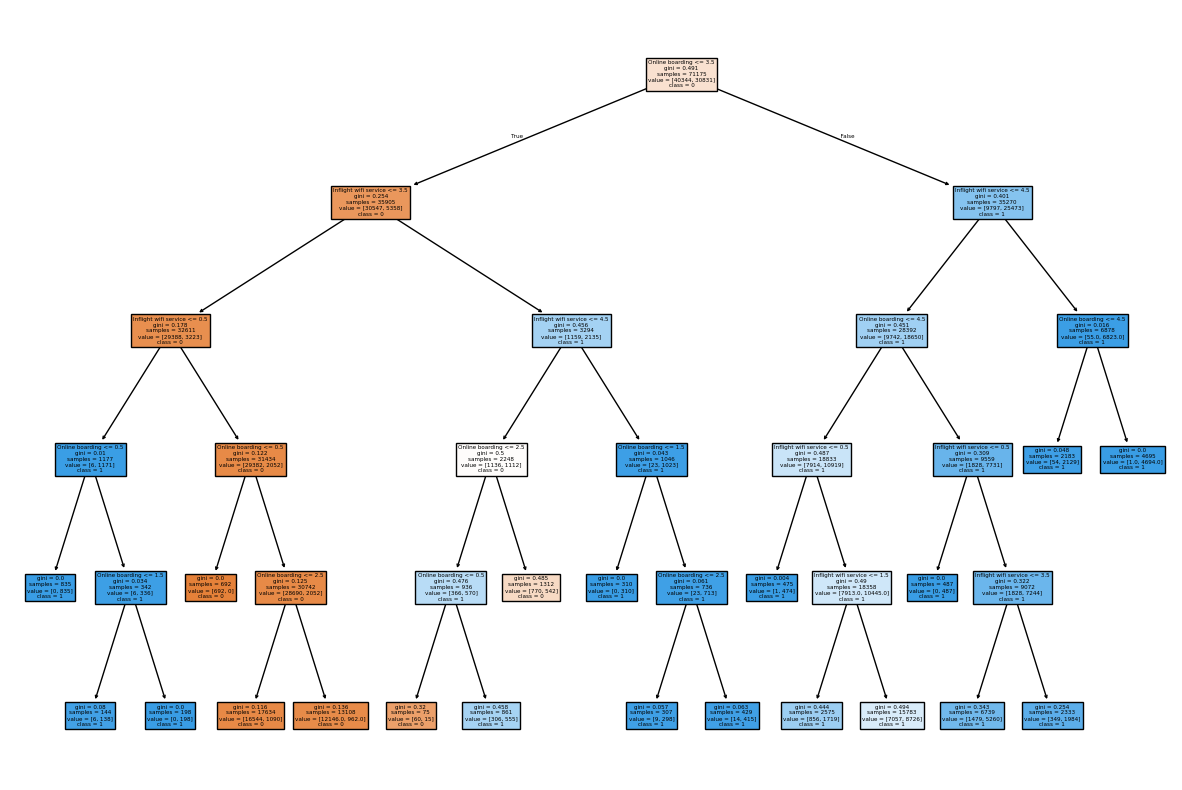

In [62]:
# Ваш код здесь
plt.figure(figsize=(15,10))
plot_tree(model, filled=True, feature_names=X_train[['Online boarding', 'Inflight wifi service']].columns, class_names=[str(i) for i in model.classes_])
plt.show()

`Дерево получилось нессимиитричным, ссимметричные деревья имеют свои преимущества, поэтому в каком то смысле хуже`

### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


<Axes: >

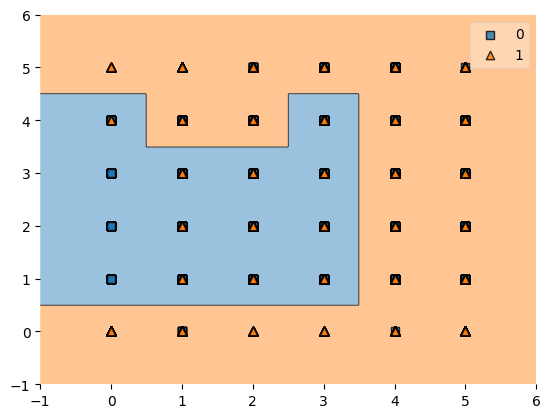

In [63]:
# Ваш код здесь

plot_decision_regions(X_train[['Online boarding', 'Inflight wifi service']].values, y_train.values, clf=model)

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

In [64]:
# замените X_train_example на вашу переменную

#fig, ax = plt.subplots(3, 3, figsize=(20, 20))

#for row in range(3):
#    for col in range(3):
#        inds = np.random.choice(X_train.index, size=X_train.shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность
#
#       tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
#        tree_exp.fit(X_train.loc[inds, :], y_train[inds].reset_index(drop=True))
#
#        plot_decision_regions(clf=tree_exp, X=np.array(X_train.iloc[:100, :]), y=np.array(y_train[:100].reset_index(drop=True)), ax=ax[row][col])

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [65]:
# замените X_train_example на вашу переменную (ohe-encoded)

%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_enc, y_train)
    y_predicted_train = DT.predict(X_train_enc)
    y_predicted_val = DT.predict(X_val_enc)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [66]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [67]:
# you know what to do

params ={'max_depth': np.arange(2,10),
         'min_samples_split':np.arange(2,10,2),
         'min_samples_leaf':np.arange(1,10,2)}

gs = GridSearchCV(DecisionTreeClassifier(), params, cv=5, scoring='accuracy')

gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_leaf': array([1, 3, 5, 7, 9]),
                         'min_samples_split': array([2, 4, 6, 8])},
             scoring='accuracy')

In [68]:
gs.best_estimator_, gs.best_score_

(DecisionTreeClassifier(max_depth=9), 0.9396979276431331)

In [69]:
model_tree_clf = DecisionTreeClassifier(max_depth=9, min_samples_split=8)

model_tree_clf.fit(X_train, y_train)

prediction = model_tree_clf.predict(X_val)

accuracy_score(y_val, prediction)

0.9320939077972326

### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [70]:
with open('DT.pkl', 'wb') as f:
  pickle.dump(model_tree_clf, f)
  pass

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [71]:
# Ваш код здесь
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

prediction = rf.predict(X_val)

accuracy_score(y_val, prediction)

0.9626532887402452

### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

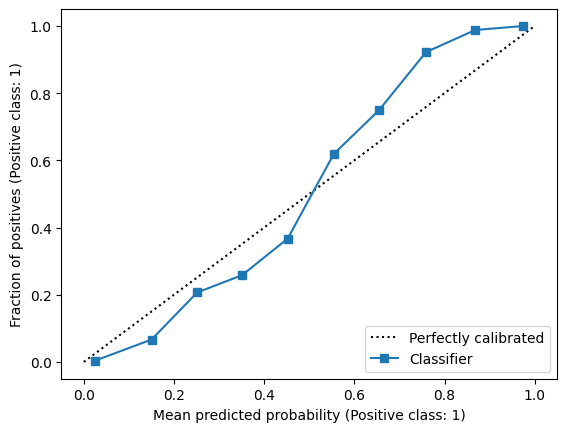

In [72]:
# Ваш код здесь

y_proba_rf = rf.predict_proba(X_val)[:, 1]

disp = CalibrationDisplay.from_predictions(y_val, y_proba_rf, n_bins=10)
plt.show()

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?



```
Деревья не очень гибкие для присвоения корректных вероятностей. Вероятность будет зависеть от количества данных в листе, то есть, если, например, в листе окажется лишь один объект, то дерево ему будет присваивать либо 100% вероятность, либо 0.  
```



### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

In [73]:
# Ваш код здесь

lr = LogisticRegression()

lr.fit(X_train, y_train)

prediction = lr.predict(X_val)

accuracy_score(y_val, prediction)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.788609089120598

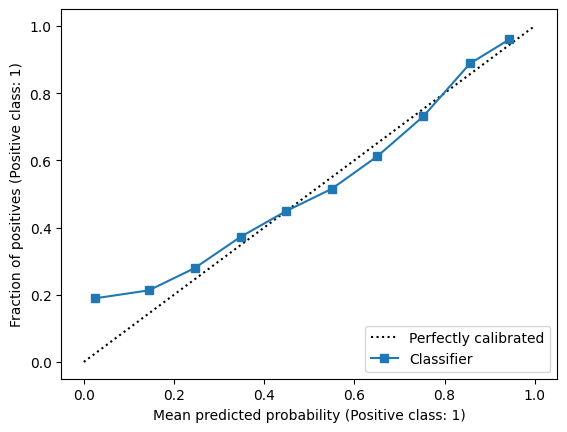

In [74]:
y_proba_lr = lr.predict_proba(X_val)[:, 1]

disp = CalibrationDisplay.from_predictions(y_val, y_proba_lr, n_bins=10)
plt.show()

Мы немного переоцениваем предсказанные низкие вероятности

```
У меня почему то ровно наоборот получилось, модель недооценивает низкие предсказания
  
```

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?



```
В логистической регрессии используется сигмоидная функция, которая "запихивает" данные в орезок от 0 до 1, а коэффициенты подбираются с помощью метода максимального правдоподобия, поэтому, считается, что логистическая регрессия корректно предсказывает вероятности
  
```


### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

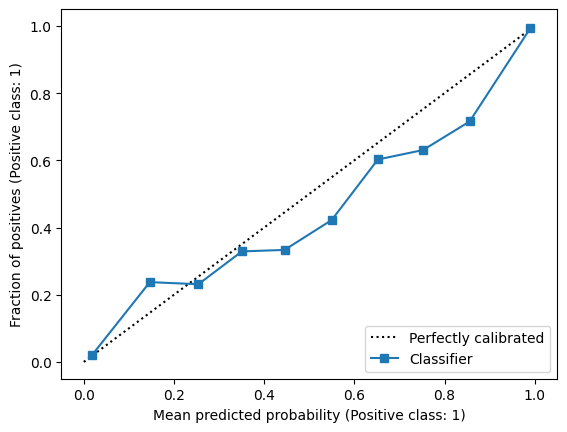

In [75]:
# Ваш код здесь (Logreg)

from sklearn.calibration import CalibratedClassifierCV

lr_calibr = LogisticRegression()

lr_calibr.fit(y_proba_rf.reshape(-1, 1), y_val)

lr_calibrated = lr_calibr.predict_proba(y_proba_rf.reshape(-1,1))[:,1]

disp = CalibrationDisplay.from_predictions(y_val, lr_calibrated, n_bins=10)
plt.show()

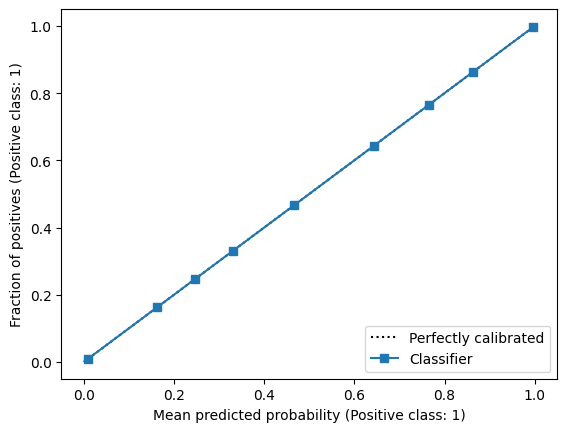

In [76]:
# Ваш код здесь (isoreg)

iso = IsotonicRegression()

iso.fit(y_proba_rf, y_val)

iso_calibrated = iso.transform(y_proba_rf)

disp = CalibrationDisplay.from_predictions(y_val, iso_calibrated, n_bins=10)
plt.show()

```
Калибровка с помощью логистической регрессии ухудшила результат, изотоническая регрессия улучшила, но как то подозрительно сильно улудишла)))
  
```

### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)



```
Гистограммная калибровка
Строим гистограмму для предсказанных вероятностей и корректируем их, чтобы они лучше соответствовали данным.
https://alexanderdyakonov.wordpress.com/2020/03/27/%D0%BF%D1%80%D0%BE%D0%B1%D0%BB%D0%B5%D0%BC%D0%B0-%D0%BA%D0%B0%D0%BB%D0%B8%D0%B1%D1%80%D0%BE%D0%B2%D0%BA%D0%B8-%D1%83%D0%B2%D0%B5%D1%80%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8/
```


### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

In [77]:
# Ваш код здесь

error_dt, bias_dt, var_dt = bias_variance_decomp(rf, X_train.values, y_train.values, X_val.values, y_val.values, loss ='0-1_loss', random_seed=np.random.seed(42), num_rounds=100)
error_dt, bias_dt, var_dt

(0.039384221916191224, 0.037609023542527376, 0.008961899140927274)


```
Отличаются, в случайном лесе разброс в разы меньше, чем в случае одного дерева. Это совпадает с теорией, с помощью случайного леса нам удётся снизить разброс и сохранить +- такое же смещение как у одного дерва


```

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [78]:
# Ваш код здесь
error_dt, bias_dt, var_dt = bias_variance_decomp(lr, X_train.values, y_train.values, X_val.values, y_val.values, loss ='0-1_loss', random_seed=np.random.seed(42), num_rounds=200)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [79]:
error_dt, bias_dt, var_dt

(0.21577726408289066, 0.21683389074693424, 0.0218442192930684)


```
В логистической регрессии тоже небольшого разброса. Опять же я не понимаю, почему получается что ошибка меньше чем сумма смещения и разброса.
```

### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [80]:
from scipy.stats import randint, uniform

# Ваш код здесь
params = {'n_estimators': randint(5, 150),
          'max_depth':randint(5, 50),
          'min_samples_split':uniform(0.01, 0.99),
          'min_samples_leaf':randint(1, 50)}

search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=params, n_iter=5, cv=5, scoring='accuracy')

search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b2cdd6dec10>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b2cdd516750>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b2cdd793a10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b2cdd690490>},
                   scoring='accuracy')

In [81]:
search.best_params_, search.best_score_

({'max_depth': 28,
  'min_samples_leaf': 3,
  'min_samples_split': 0.03037864935284442,
  'n_estimators': 6},
 0.919171057253249)

## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [82]:
# замените X_train_enc на ваш трейн

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too fe

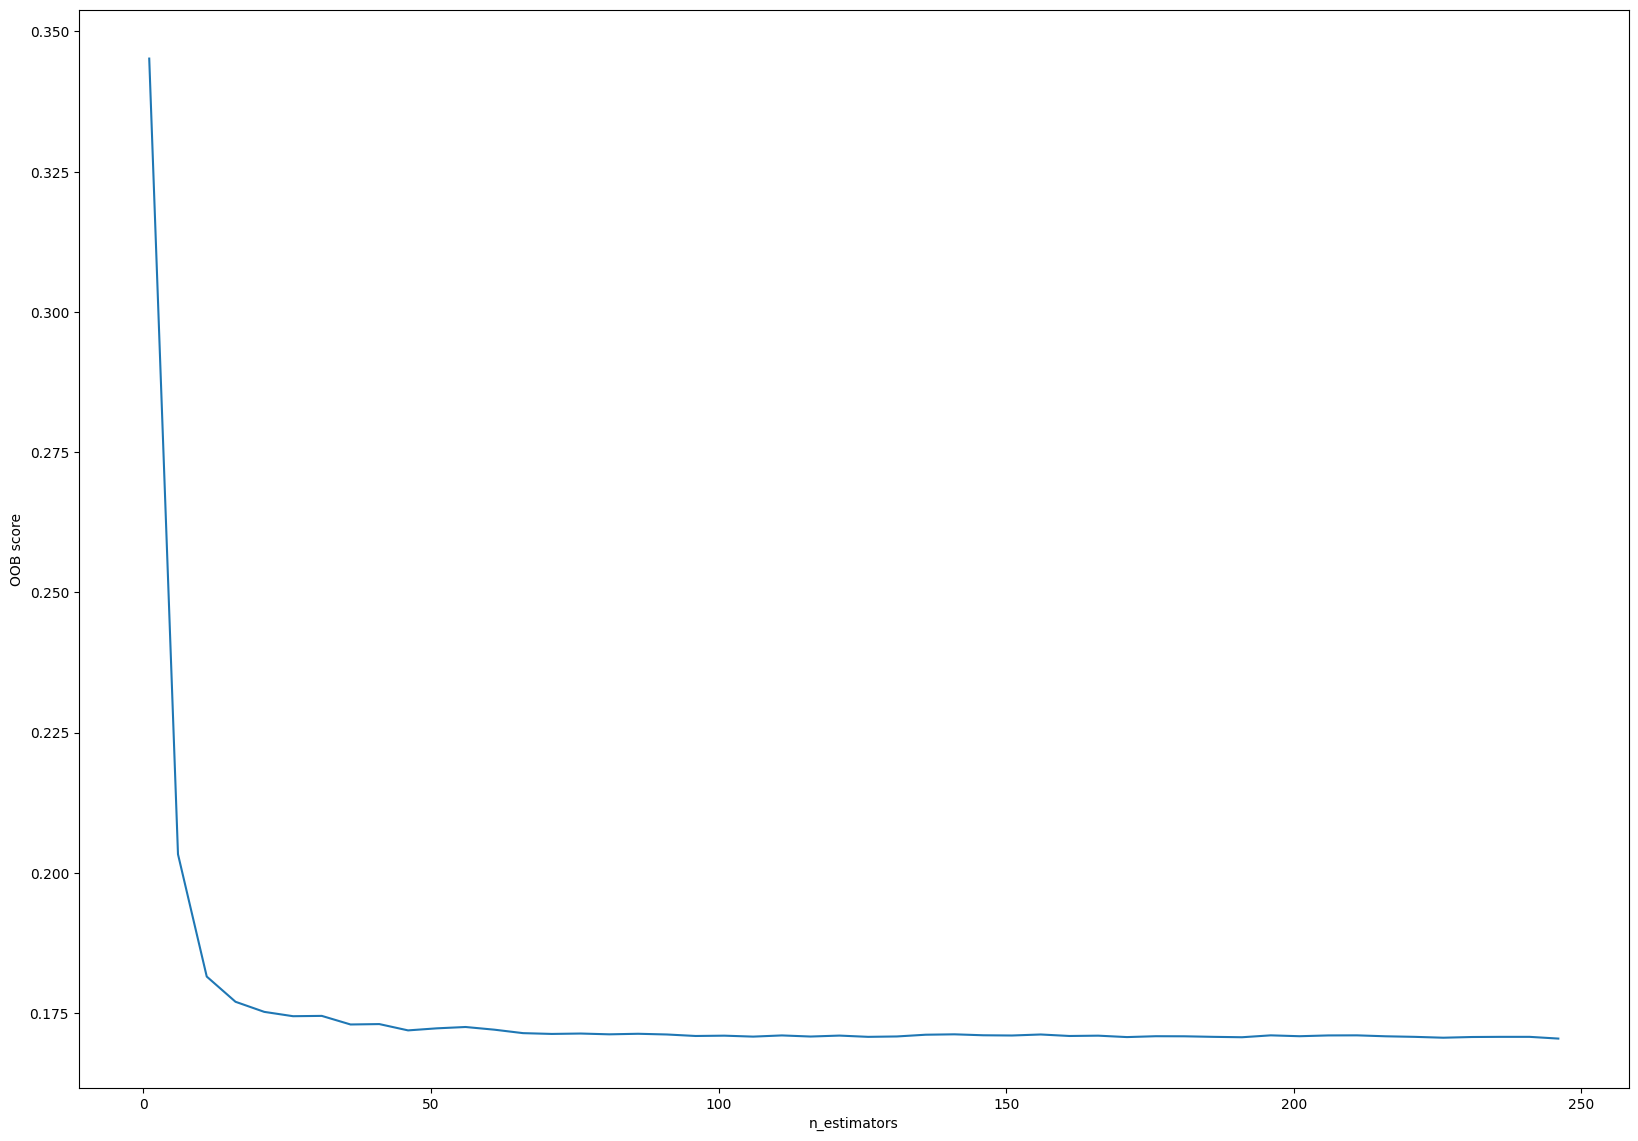

In [83]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


In [84]:
# Ваш код здесь
rf.feature_importances_

array([0.02930357, 0.03081905, 0.01084743, 0.01183824, 0.06252438,
       0.01470937, 0.13744576, 0.0386578 , 0.01990021, 0.0101543 ,
       0.03508455, 0.02345023, 0.02681908, 0.15920762, 0.01523821,
       0.02747846, 0.03717754, 0.02351974, 0.00297209, 0.00323556,
       0.02996804, 0.02556738, 0.05991073, 0.05340257, 0.07366965,
       0.03445072, 0.00264774])

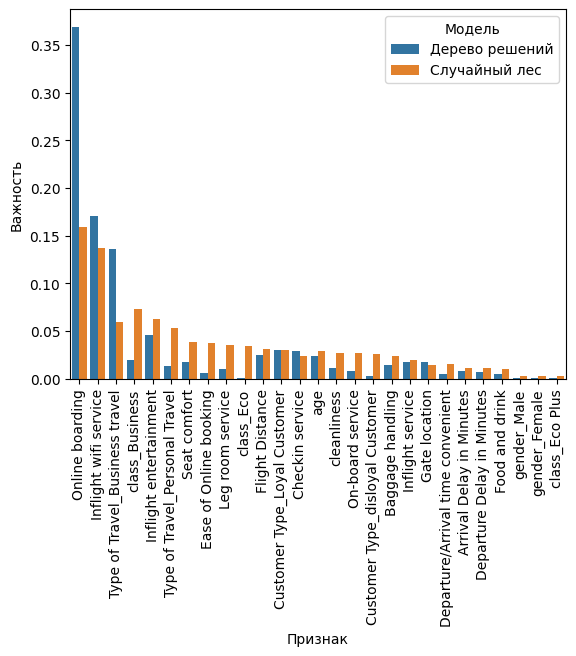

In [85]:
# Ваш код здесь

df_importance = pd.DataFrame({'Признак':np.tile(X_train.columns, 2),
                              'Важность':np.concatenate([dt.feature_importances_, rf.feature_importances_]),
                              'Модель':['Дерево решений']*len(X_train.columns)+['Случайный лес']*len(X_train.columns)})
sns.barplot(df_importance.sort_values(by='Важность', ascending=False), x='Признак', y='Важность', hue='Модель')
plt.xticks(rotation=90)
plt.show()

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

In [86]:
with open('DT.pkl', 'wb') as f:
  pickle.dump(rf, f)
  pass

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

100%|===================| 1996/2000 [03:12<00:00]       

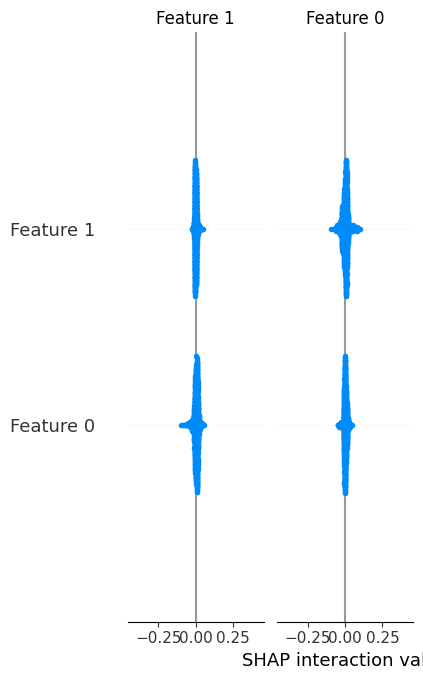

In [87]:
# Ваш код здесь

X_random = X_val.sample(n=1000, random_state=42)

explainer = shap.TreeExplainer(rf, X_random)

shap_values = explainer.shap_values(X_random)

shap.summary_plot(shap_values)

plt.show()

`Ваш ответ здесь`

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

`Ваш ответ здесь`

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [88]:
# Ваш код здесь


`Ваш ответ здесь`

## Котобонус!

0.25 балла

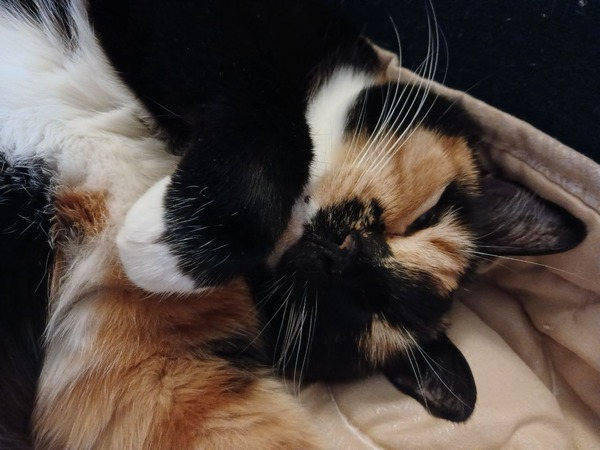

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?